# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)
feature_cols = X.columns

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [5]:
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [6]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split
j, split, gain = best_split(X, y, 5)
j, split, gain

(0, 2014.0, 0.23223870086324505)

In [7]:
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]
print(y.shape[0], y_l.shape[0], y_r.shape[0])
print(y.mean(), y_l.mean(), y_r.mean())

13150 4169 8981
0.5795437262357415 0.07939553849844087 0.8117136176372342


In [8]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [9]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

In [10]:
y_pred = tree_predict(X_test, tree)
from sklearn import metrics
print(metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

0.8833041106565361 0.8619815668202765


# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [11]:
n_B = 10
n_samples = data.shape[0]
acc = []
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
for i, sample in enumerate(samples):
    X_trains = data.iloc[sample, 0:-1]
    y_trains = data.iloc[sample, -1]
    tree = tree_grow(X_trains, y_trains, level=0, min_gain=0.001, max_depth=3, num_pct=10)
    y_pred[i] = tree_predict(X_test, tree)
    acc.append([metrics.f1_score(y_pred[i], y_test), metrics.accuracy_score(y_pred[i], y_test)])
acc = pd.DataFrame(acc, columns=['F1 Score','Acc'])
print(acc)
print('Best Accuracy Score: ')
print(acc.loc[acc['Acc'].idxmax()])

   F1 Score       Acc
0  0.891186  0.866590
1  0.891640  0.868894
2  0.891480  0.867051
3  0.893200  0.866820
4  0.883675  0.862903
5  0.884608  0.863364
6  0.884771  0.862442
7  0.891927  0.865207
8  0.884114  0.860829
9  0.872494  0.853456
Best Accuracy Score: 
F1 Score    0.891640
Acc         0.868894
Name: 1, dtype: float64


# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [12]:
from sklearn.ensemble import RandomForestClassifier
feature_range = range(1, len(feature_cols)+1)
accuracy_scores = []
import random
for feature in feature_range:
    variables = random.choices(feature_cols, k = feature)
    X_trains = X_train[variables]
    tree = tree_grow(X_trains, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
    y_predi = tree_predict(X_test[variables], tree)
    accuracy_scores.append([feature, metrics.f1_score(y_predi, y_test), metrics.accuracy_score(y_predi, y_test), variables])
accuracy_scores = pd.DataFrame(accuracy_scores, columns=['Feature', 'F1 Score','Acc', 'Features Selected'])
accuracy_scores

,Feature,F1 Score,Acc,Features Selected
0,1,0.736168,0.582488,[M_CamryBase]
1,2,0.870919,0.841475,"[Mileage, M_CamryLE]"
2,3,0.809931,0.728341,"[M_Camry4dr, M_Camry, M_Camry]"
3,4,0.813109,0.743779,"[M_Camry, M_CamryBase, M_Camry4dr, M_CamrySE]"
4,5,0.882799,0.861060,"[M_Camry4dr, Year, Mileage, M_CamryLE, M_Camry..."
5,6,0.870919,0.841475,"[M_Camry, M_Camry, M_CamryLE, M_CamryBase, M_C..."
6,7,0.882799,0.861060,"[Mileage, M_Camry, M_CamryLE, M_CamryL, M_Camr..."
7,8,0.882799,0.861060,"[M_CamryXLE, M_CamrySE, M_CamryBase, Mileage, ..."
8,9,0.882799,0.861060,"[M_Camry4dr, Year, Mileage, M_CamryXLE, M_Camr..."


In [13]:
print('Best Accuracy Score: ')
print(accuracy_scores.loc[accuracy_scores['Acc'].idxmax()])

Best Accuracy Score: 
Feature                                                              5
F1 Score                                                      0.882799
Acc                                                            0.86106
Features Selected    [M_Camry4dr, Year, Mileage, M_CamryLE, M_Camry...
Name: 4, dtype: object


El accuracy score modificando los features del modelo da .8610 mientras que el modelo original da 0.8619 y el modelo con Bagging tiene un score de .08917 por lo que 

# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [14]:
#NO ENTIENDO QUE TOCA HACER ACÁ

# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)


(0.8642956487184581, 0.8426267281105991)

# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [16]:
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Acc           0.840978
Estimador    10.000000
Name: 0, dtype: float64


Text(0, 0.5, 'Accuracy')

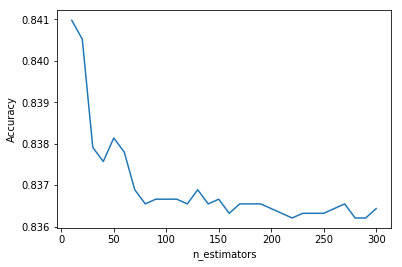

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
df = pd.DataFrame(list(zip(accuracy_scores, estimator_range)), columns=['Acc','Estimador'])
print(df.loc[df['Acc'].idxmax()])
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [18]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=10, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())


Acc             0.84529
Max_features    7.00000
Name: 6, dtype: float64


Text(0, 0.5, 'Accuracy')

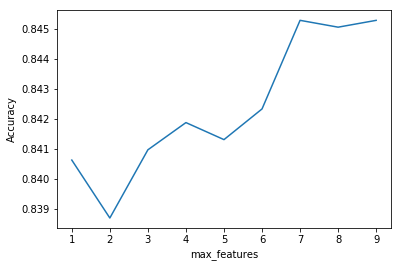

In [19]:
df = pd.DataFrame(list(zip(accuracy_scores, feature_range)), columns=['Acc','Max_features'])
print(df.loc[df['Acc'].idxmax()])
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [20]:
feature_range = range(1, 10)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=10, max_features=9, random_state=1, n_jobs=-1, max_depth=feature)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())


Acc          0.884222
Max_depth    5.000000
Name: 4, dtype: float64


Text(0, 0.5, 'Accuracy')

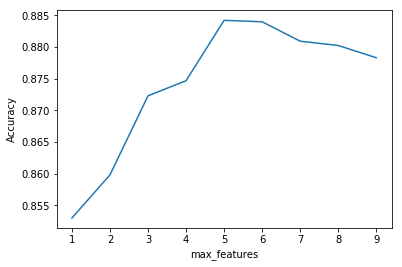

In [21]:
df = pd.DataFrame(list(zip(accuracy_scores, feature_range)), columns=['Acc','Max_depth'])
print(df.loc[df['Acc'].idxmax()])
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [22]:
clf = RandomForestClassifier(n_estimators=10, max_features=9, random_state=1, n_jobs=-1, max_depth=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
3,M_Camry4dr,0.000000
4,M_CamryBase,0.000000
5,M_CamryL,0.000432
7,M_CamrySE,0.000544
2,M_Camry,0.007044
8,M_CamryXLE,0.007209
6,M_CamryLE,0.015897
0,Year,0.151363
1,Mileage,0.817511


In [23]:
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.8990966749951951, 0.8790322580645161)